3.1 Following the example from the binder, choose different features (you can find all the features in the GHZ paper from slides 1.d) and different date ranges and train a tree with depth 4. Print the visualization and the feature importance. 

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

In [1]:
import numpy as np 
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import QuantileTransformer

In [2]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [3]:
df = pd.read_sql(
    """
    select ticker, date, acc, chcsho, egr, pchcurrat, ret
    from data
    where date between '2020-06' and '2020-07'
    """, 
    conn
)
features = ["acc", "chcsho", "egr", "pchcurrat"]

In [4]:
qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
  "date", 
  group_keys=False
)[features + ["ret"]].apply(qtxs)

In [5]:
df = df.dropna()

Xtrain = df[df.date == '2020-06'][features]
ytrain = df[df.date == '2020-06']["ret"]

model = DecisionTreeRegressor(
  max_depth=4,
  random_state=1
)
model.fit(Xtrain, ytrain)

DecisionTreeRegressor(max_depth=4, random_state=1)

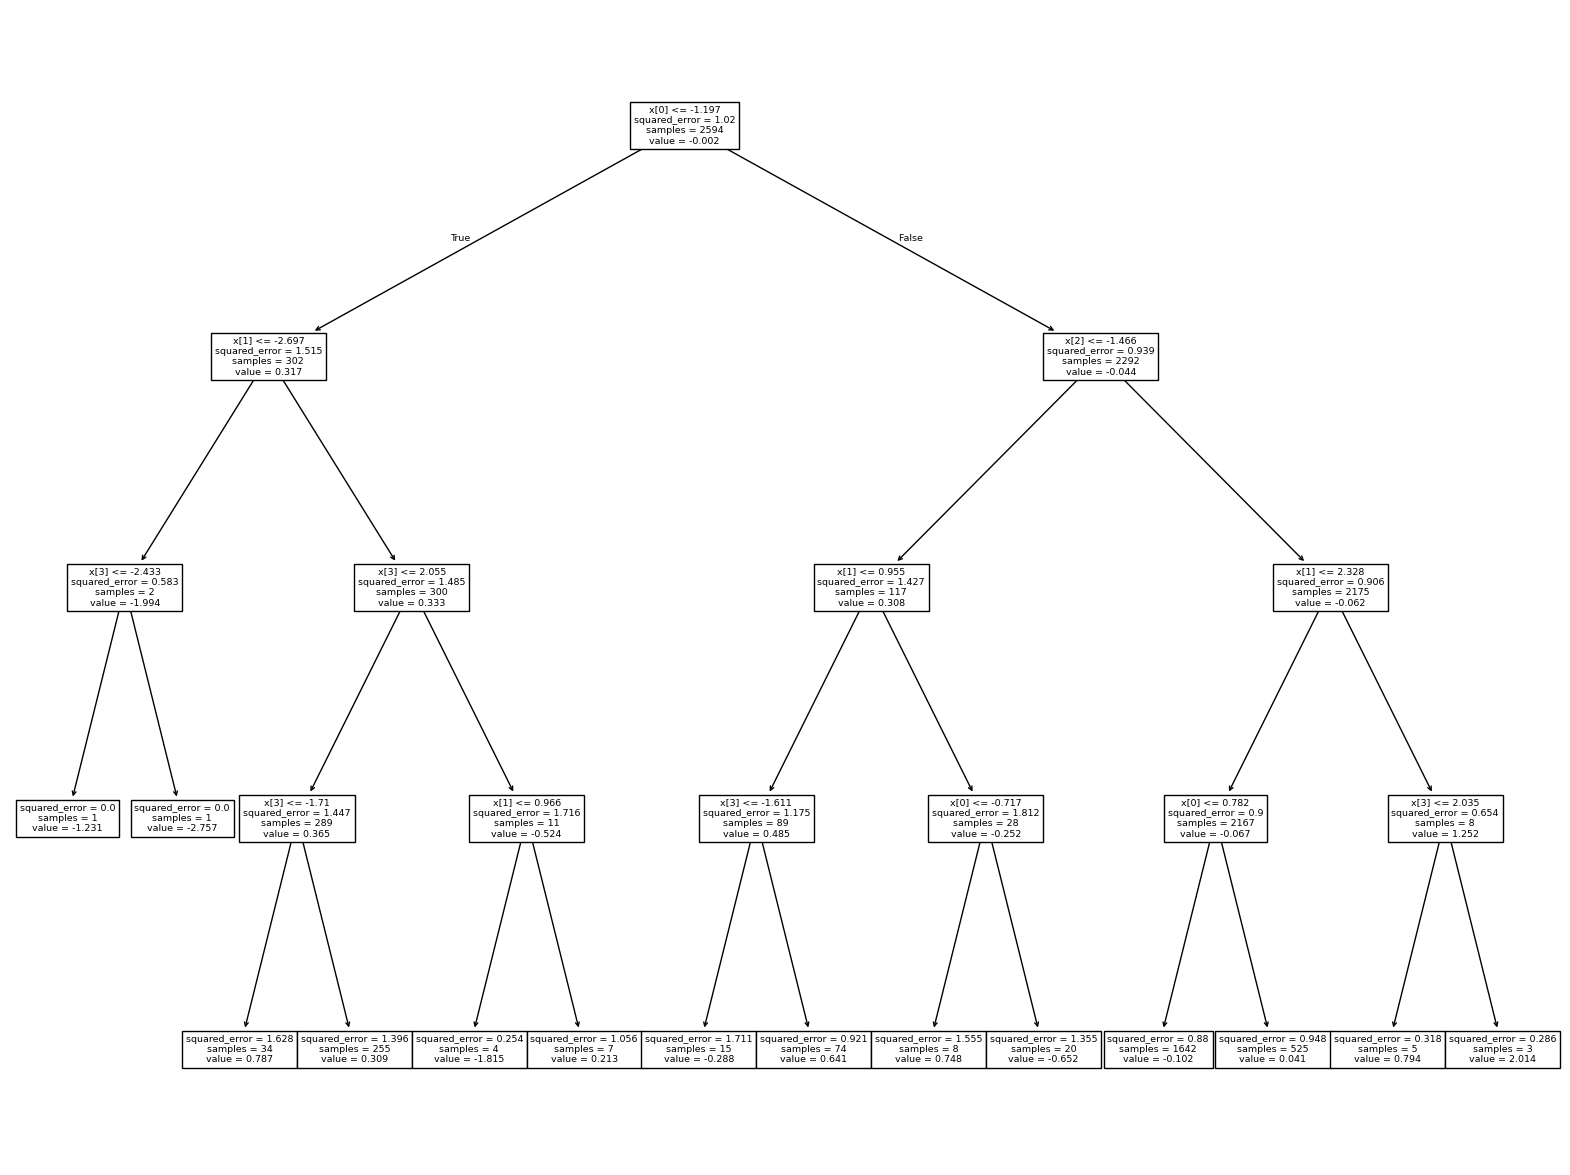

In [6]:
plt.figure(figsize=(20, 15))
_ = plot_tree(model)

In [7]:
feature_importance = pd.Series(model.feature_importances_, index=Xtrain.columns)
print(feature_importance)

acc          0.370691
chcsho       0.319556
egr          0.104546
pchcurrat    0.205207
dtype: float64


3.2 For the tree model from the previous exercise, explore which depth is the best hyperparameter for the model. Plot your experiments.

Note: You can continue working on your previous ipynb file and upload that or a pdf of your notebook (preferred).

In [8]:
model.score(Xtrain, ytrain)

0.05520640378082042

In [9]:
Xtest = df[df.date == '2020-07'][features]
ytest = df[df.date =='2020-07']["ret"]
model.score(Xtest, ytest)

-0.05964636160503556

In [10]:
train_score = []
test_score = []
for i in range(1, 11):
    model = DecisionTreeRegressor(
    max_depth=i,
    random_state=10
    )
    model.fit(Xtrain, ytrain)
    train_score.append(model.score(Xtrain, ytrain))
    test_score.append(model.score(Xtest, ytest))

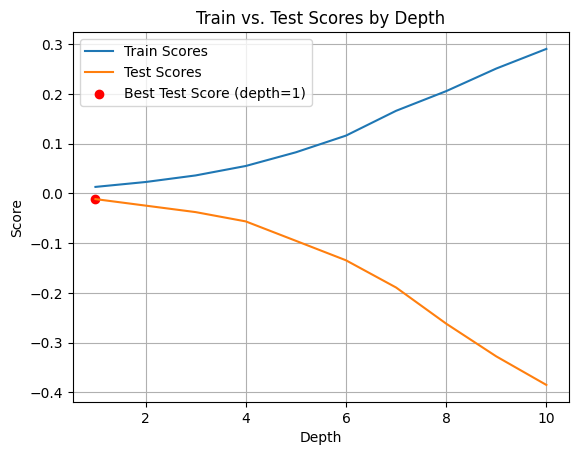

In [11]:
depths = range(1,11)

best_depth = test_score.index(max(test_score)) + 1

plt.plot(depths, train_score, label='Train Scores')
plt.plot(depths, test_score, label='Test Scores')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Train vs. Test Scores by Depth')
plt.scatter(best_depth, max(test_score), color='red', label=f'Best Test Score (depth={best_depth})')
plt.legend()

plt.grid(True)

plt.show()

3.3 Following the example from the binder, choose different features (you can find all the features in the GHZ paper from slides 1.d), and different date ranges and train a forest model. Find the best depth and learning rate for it. 

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

In [12]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
import matplotlib.pyplot as plt

In [13]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

df = pd.read_sql(
    """
    select ticker, date, acc, bm, cash, mom6m, ret
    from data
    where date between '2020-06' and '2020-07'
    """, 
    conn
)
features = ["acc", "cash", "bm", "mom6m"]

qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
    "date", 
    group_keys=False
)[features + ["ret"]].apply(qtxs)

df = df.dropna()

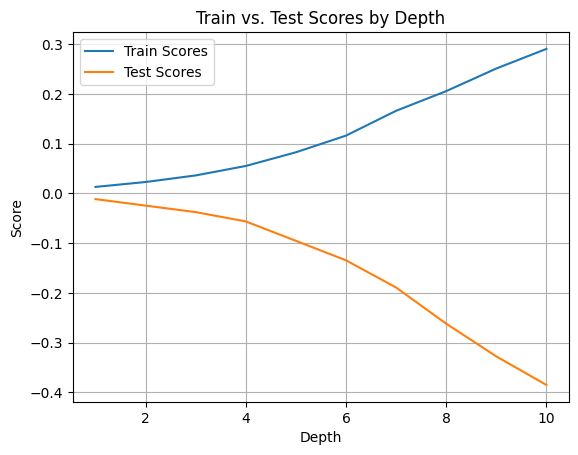

In [14]:
Xtrain = df[df.date=='2020-06'][features]
ytrain = df[df.date=='2020-06']["ret"]
Xtest = df[df.date=='2020-07'][features]
ytest = df[df.date=='2020-07']["ret"]

# Random Forest analysis
train_scores = []
test_scores = []
depths = range(1, 11)

for i in depths:
    model = RandomForestRegressor(
        max_depth=i,
        random_state=0
    )
    model.fit(Xtrain, ytrain)
    train_scores.append(model.score(Xtrain, ytrain))
    test_scores.append(model.score(Xtest, ytest))

plt.plot(depths, train_score, label='Train Scores')
plt.plot(depths, test_score, label='Test Scores')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Train vs. Test Scores by Depth')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [15]:
learning_rates = [0.01, 0.05, 0.1, 0.2]
test_scores_gb = []

for lr in learning_rates:
    lr_scores = []
    for depth in depths:
        model = GradientBoostingRegressor(
            max_depth=depth,
            learning_rate=lr,
            random_state=0
        )
        model.fit(Xtrain, ytrain)
        lr_scores.append(model.score(Xtest, ytest))
    test_scores_gb.append(lr_scores)

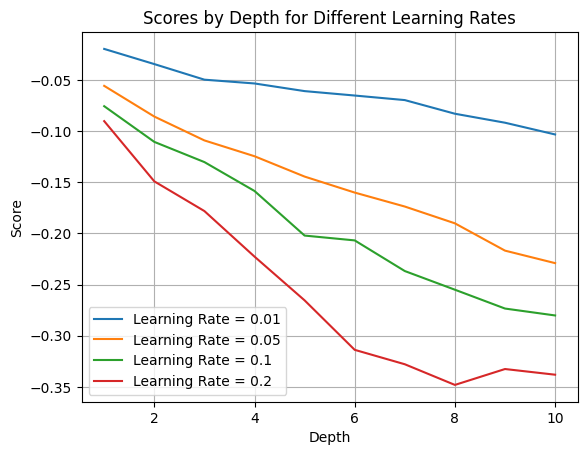

In [16]:
plt.plot(depths, test_scores_gb[0], label='Learning Rate = 0.01')
plt.plot(depths, test_scores_gb[1], label='Learning Rate = 0.05')
plt.plot(depths, test_scores_gb[2], label='Learning Rate = 0.1')
plt.plot(depths, test_scores_gb[3], label='Learning Rate = 0.2')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Scores by Depth for Different Learning Rates')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [17]:
test_scores_ab = []
for lr in learning_rates:
    lr_scores = []
    for depth in depths:
        model = AdaBoostRegressor(
            DecisionTreeRegressor(
                max_depth=depth,
                random_state=0
            ),
            learning_rate=lr,
        )
        model.fit(Xtrain, ytrain)
        lr_scores.append(model.score(Xtest, ytest))
    test_scores_ab.append(lr_scores)    

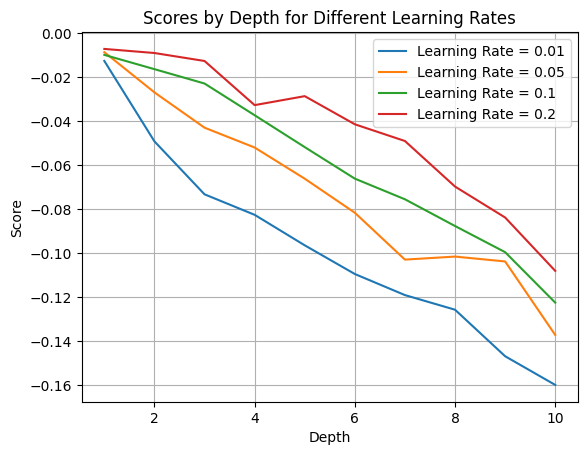

In [18]:
plt.plot(depths, test_scores_ab[0], label='Learning Rate = 0.01')
plt.plot(depths, test_scores_ab[1], label='Learning Rate = 0.05')
plt.plot(depths, test_scores_ab[2], label='Learning Rate = 0.1')
plt.plot(depths, test_scores_ab[3], label='Learning Rate = 0.2')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Scores by Depth for Different Learning Rates')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [21]:
# Find best parameters
best_depth_rf = test_scores.index(max(test_scores)) + 1
print(f"Best Random Forest depth: {best_depth_rf}")

best_gb_score = -np.inf
best_gb_params = (0, 0)
for i, lr in enumerate(learning_rates):
    for j, score in enumerate(test_scores_gb[i]):
        if score > best_gb_score:
            best_gb_score = score
            best_gb_params = (j+1, lr)

print(f"Best Gradient Boosting params: Depth: {best_gb_params[0]}, Learning Rate: {best_gb_params[1]}")

best_ab_score = -np.inf
best_ab_params = (0, 0)
for i, lr in enumerate(learning_rates):
    for j, score in enumerate(test_scores_ab[i]):
        if score > best_ab_score:
            best_ab_score = score
            best_ab_params = (j+1, lr)
print(f"Best Ada Boosting params: Depth: {best_ab_params[0]}, Learning Rate: {best_ab_params[1]}")


Best Random Forest depth: 1
Best Gradient Boosting params: Depth: 1, Learning Rate: 0.01
Best Ada Boosting params: Depth: 1, Learning Rate: 0.2


3.4 Following the example from the binder, choose different features (you can find all the features in the GHZ paper from slides 1.d), and different date ranges and train a neural network. Find the best architecture for your problem, explore a few, and post the score for it. 

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

In [22]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.neural_network import MLPRegressor
import plotly.graph_objects as go

In [23]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

df = pd.read_sql(
    """
    select ticker, date, acc, bm, cash, mom6m, ret
    from data
    where date between '2020-06' and '2020-07'
    """, 
    conn
)
features = ["acc", "cash", "bm", "mom6m"]

qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
    "date", 
    group_keys=False
)[features + ["ret"]].apply(qtxs)

df = df.dropna()

In [24]:
Xtrain = df[df.date=='2020-06'][features]
ytrain = df[df.date=='2020-06']["ret"]
model = MLPRegressor(
  hidden_layer_sizes=(4, 2),
  random_state=0
)
model.fit(Xtrain, ytrain)

model.score(Xtrain, ytrain)

0.04681391343841779

In [25]:
Xtest = df[df.date=='2020-07'][features]
ytest = df[df.date=='2020-07']["ret"]

model.score(Xtest, ytest)

-0.10431077154425883

In [26]:
train_score = []
test_score = []
architectures = [] #labels = []

for i in range(2, 16, 2):
    for j in range(2, 16, 2):
        model = MLPRegressor(
            hidden_layer_sizes=(i, j),
            max_iter=1000,
            tol=1e-4,
            early_stopping=True,
            
            random_state=0
            )
        model.fit(Xtrain, ytrain)
        train_score.append(model.score(Xtrain, ytrain))
        test_score.append(model.score(Xtest, ytest))
        architectures.append(f'({i}, {j})')
        
        for k in range(2, 16, 2):
            model = MLPRegressor(
            hidden_layer_sizes=(i, j, k),
            max_iter=1000,
            tol=1e-4,
            early_stopping=True,
            random_state=0
            )
            model.fit(Xtrain, ytrain)
            train_score.append(model.score(Xtrain, ytrain))
            test_score.append(model.score(Xtest, ytest))
            architectures.append(f'({i}, {j}, {k})')

print(f"Trained {len(train_score)} models")

Trained 392 models


In [27]:
best_idx = test_score.index(max(test_score))
best_arch = architectures[best_idx]
best_train_score = train_score[best_idx]
best_test_score = test_score[best_idx]

print(f"Best Architecture: {best_arch}")
print(f"Training Score: {best_train_score:.4f}")
print(f"Test Score: {best_test_score:.4f}")

trace = go.Scatter(
    x=train_score,
    y=test_score,
    mode='markers',
    marker=dict(
        size=5,
        sizemode='diameter',
        sizeref=0.1,
        sizemin=5,
        color=train_score,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Training Score')
    ),
    text=['NN size: {}'.format(size) for size in labels]
)
# Create a layout for the plot
layout = go.Layout(
    title='Test Score vs. Training Score for Neural Network',
    xaxis=dict(title='Training Score'),
    yaxis=dict(title='Test Score')
)

# Combine the trace and layout into a figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.add_annotation(
    x=best_train_score,
    y=best_test_score,
    text=f"Best: {best_arch}",
    showarrow=True,
    arrowhead=2
)
fig.show()

Best Architecture: (2, 6, 6)
Training Score: -0.0117
Test Score: 0.0119


NameError: name 'labels' is not defined

3.5 For one of the random forest models that you built in the previous assignments, do a grid search and find the best parameters for the model

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

In [140]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [137]:
df = pd.read_sql(
    """
    select ticker, date, acc, bm, cash, mom6m, ret
    from data
    where date between '2020-06' and '2020-07'
    """, 
    conn
)
features = ["acc", "cash", "bm", "mom6m"]

qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
    "date", 
    group_keys=False
)[features + ["ret"]].apply(qtxs)

df = df.dropna()

In [145]:
Xtrain = df[df.date=='2020-06'][features]
ytrain = df[df.date=='2020-06']["ret"]
Xtest = df[df.date=='2020-07'][features]
ytest = df[df.date=='2020-07']["ret"]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
)

grid_search.fit(Xtrain, ytrain)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 50}
Best score: 0.0239


3.6 For a neural network, do a grid search and find the best parameters for the model.

Note: Upload a .ipynb file  or a pdf of your notebook (preferred).

In [156]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [154]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

df = pd.read_sql(
    """
    select ticker, date, acc, bm, cash, mom6m, ret
    from data
    where date between '2020-06' and '2020-07'
    """, 
    conn
)
features = ["acc", "cash", "bm", "mom6m"]

qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
    "date", 
    group_keys=False
)[features + ["ret"]].apply(qtxs)

df = df.dropna()

In [165]:
Xtrain = df[df.date=='2020-06'][features]
ytrain = df[df.date=='2020-06']["ret"]
Xtest = df[df.date=='2020-07'][features]
ytest = df[df.date=='2020-07']["ret"]

layers = list(product(range(2, 8, 2), repeat=3))

gs = GridSearchCV(
    estimator=MLPRegressor(max_iter=500, random_state=1),
    param_grid={'hidden_layer_sizes': layers},
).fit(Xtrain, ytrain)
print(f"Best parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_:.4f}")

Best parameters: {'hidden_layer_sizes': (4, 2, 2)}
Best score: 0.0348
